In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

In [3]:
comments_train=pd.read_csv('train.csv')
comments_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
comments_test=pd.read_csv('test.csv', encoding=('ISO-8859-1'),low_memory=False)
comments_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
print("\nFeatures Present in the Dataset: \n", comments_train.columns)
shape=comments_train.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", comments_train.dtypes)
print("\nDataset contains any NaN/Empty cells : ", comments_train.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", comments_train.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in comments_train.columns.values:
    print("Number of unique values of {} : {}".format(col, comments_train[col].nunique()))


Features Present in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Total Number of Rows :  159571
Total Number of Features :  8


Data Types of Features :
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Dataset contains any NaN/Empty cells :  False

Total number of empty rows in each feature:
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of id : 159571
Number of unique values of comment_text : 159571
Number of unique values of malignant : 2
Number of unique values of highly_malignant : 2
Number

In [6]:
cols=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for col in cols:
    print("Number of value_counts of {} : {}".format(col, comments_train[col].nunique()))
    print(comments_train[f'{col}'].value_counts())

Number of value_counts of malignant : 2
0    144277
1     15294
Name: malignant, dtype: int64
Number of value_counts of highly_malignant : 2
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value_counts of rude : 2
0    151122
1      8449
Name: rude, dtype: int64
Number of value_counts of threat : 2
0    159093
1       478
Name: threat, dtype: int64
Number of value_counts of abuse : 2
0    151694
1      7877
Name: abuse, dtype: int64
Number of value_counts of loathe : 2
0    158166
1      1405
Name: loathe, dtype: int64


In [7]:
comments_train.drop(['id'],axis=1,inplace=True)

In [8]:
comments_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
comments_train.isnull().sum()

comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [10]:
lens = comments_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.138847284281, 590.7253812496405, 5000)

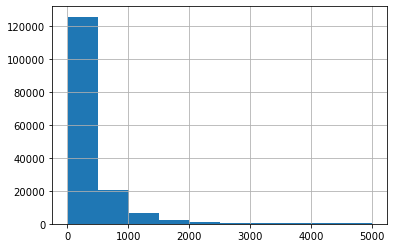

In [11]:
lens.hist();

In [12]:
comments_train.corr().style.background_gradient(cmap='YlGnBu')

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [13]:
label_cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
comments_train['label'] = 1-comments_train[label_cols].max(axis=1)
comments_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,label
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
comments_train.label.value_counts()

1    143346
0     16225
Name: label, dtype: int64

In [15]:
comments_train['length'] = comments_train.comment_text.str.len()
comments_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67


In [16]:
#     Here I have made a function in which all the Data cleaning steps like removing data which is not useful like 
#       email adress, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization technique, filtering documents using Stopwords, using POS tagging,
#      all these type of data preprocessing steps are being perormed with th ehelp of the function defined below.

# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning...
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [ ]:
comments_train["clean_comment_text"] = comments_train["comment_text"].apply(lambda x: Processed_data(x))

In [ ]:
comments_train["clean_comment_text"]

In [ ]:
comments_train['Clean_length'] = comments_train.clean_comment_text.str.len()
comments_train.head()

In [ ]:
comments_train[comments_train['label']==0]

In [ ]:
comments_train[comments_train['label']==1]

In [ ]:
x=comments_train.iloc[:,2:8].sum()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Malignant and Non Malignant comments Counts")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comments Type ', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(comments_train['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [ ]:
dictionary = corpora.Dictionary(data)
print(dictionary)

In [ ]:
comments_train['label'].value_counts()

In [ ]:
ax = comments_train['label'].value_counts().plot(kind='barh', figsize=(15,7),color="coral", fontsize=13)
ax.set_alpha(0.8)

ax.set_title("Malignant Vs Not Malignant Comments", fontsize=18)
ax.set_xlabel("Counts",  fontsize=18)
ax.set_ylabel("'1: Not Malignant'            '0:  Malignant'", fontsize=18)
totals = []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')

In [ ]:
count1 = Counter(" ".join(comments_train[comments_train['label']==0]["clean_comment_text"]).split()).most_common(200)
count2 = Counter(" ".join(comments_train[comments_train['label']==1]["clean_comment_text"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df['Malignant Words']=count1
df['Not Malignant Words']=count2
df.head(10)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

In [ ]:
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==1],"NOT MALIGNANT WORDS")

In [ ]:
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==0],"MALIGNANT WORDS")

In [ ]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['length'],bins=20,ax=ax[1],label='Not MALIGNANT wordsdistribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [ ]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['Clean_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['Clean_length'],bins=20,ax=ax[1],label='Not MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [ ]:
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [ ]:
x=Tf_idf_train(comments_train['clean_comment_text'])

In [ ]:
print("Shape of x: ",x.shape)
y = comments_train['label'].values
print("Shape of y: ",y.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

LR=LogisticRegression()
MNB=MultinomialNB()
PAC=PassiveAggressiveClassifier()
DT=DecisionTreeClassifier()

In [ ]:
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB',MNB))
models.append(('PassiveAggressiveClassifier',PAC))
models.append(('DecisionTreeClassifier',DT))

In [ ]:
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

In [ ]:
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
lg_loss=[]

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
            
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
       
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
        
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')  
    
    loss = log_loss(y_test,y_pred)
    print('Log loss : ', loss)
    lg_loss.append(loss)
    print('\n')
      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [ ]:
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_Auc_curve':rocscore,'Log_Loss':lg_loss}) 
result.style.background_gradient(cmap='YlGnBu')

In [ ]:
sns.barplot(y=Model,x=Acc_score)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=57,test_size=.30,stratify=y)
PAC=PassiveAggressiveClassifier()
PAC.fit(x_train,y_train)
PAC.score(x_train,y_train)
PACpred=PAC.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,PACpred))
print('Log loss : ', log_loss(y_test,PACpred))
print('Confusion Matrix:',confusion_matrix(y_test,PACpred))
print('Classification Report:','\n',classification_report(y_test,PACpred))

In [ ]:
fig, ax =plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, PACpred),annot=True,linewidths=1,center=0,cmap='YlGnBu')
plt.xlabel("True label")
plt.ylabel("Predicted label")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
f,ax = plt.subplots(figsize = (15,6))
fpr, tpr, thresholds = roc_curve(y_test, PACpred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, PACpred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('PassiveAggressiveClassifier')

In [ ]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [ ]:
comments_test["clean_comment_text"] = comments_test["comment_text"].apply(lambda x: Processed_data(x))
x_testing_data=Tf_idf_test(comments_test['clean_comment_text'])

In [ ]:
x_testing_data.shape

In [ ]:
Prediction=PAC.predict(x_testing_data)
testM['Predicted values']=Prediction
testM

In [ ]:
testM.to_csv('Malignant_Comment_Classifier_Predict.csv')

In [ ]:
import joblib
joblib.dump(PAC,'Malignant_Comment_Classifier_Predict.pkl')